In [2]:
import sys
import os
from IPython.display import Image
import json
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.dom.minidom as minidom
import xml.etree.cElementTree as cet
import xml.etree.ElementTree as et
%matplotlib inline

{'fiat': 4087, 'chevrolet': 3946, 'volkswagen': 3872, 'renault': 2791, 'honda': 2122, 'ford': 2059, 'peugeot': 1154, 'hyundai': 854, 'citroen': 824, 'toyota': 660, 'nissan': 550, 'mercedes-benz': 490, 'kia': 370, 'volvo': 357, 'mitsubishi': 328, 'yamaha': 228, 'bmw': 160, 'audi': 80, 'jac': 70, 'subaru': 70, 'suzuki': 65, 'mini': 60, 'marcopolo': 50, 'chery': 40, 'captiva': 40, 'ssangyong': 40, 'chev': 30, 'omega': 20, 'kawasaki': 20, 'dodge': 20, 'sundown': 20, 'dafra': 20, 'seat': 20, 'chrysler': 20, 'land': 20, 'jaguar': 12, 'triumph': 10, 'jeep': 10, 'kasinski': 10, 'shineray': 10, 'hafei': 10, 'classic': 10}
Classes 42


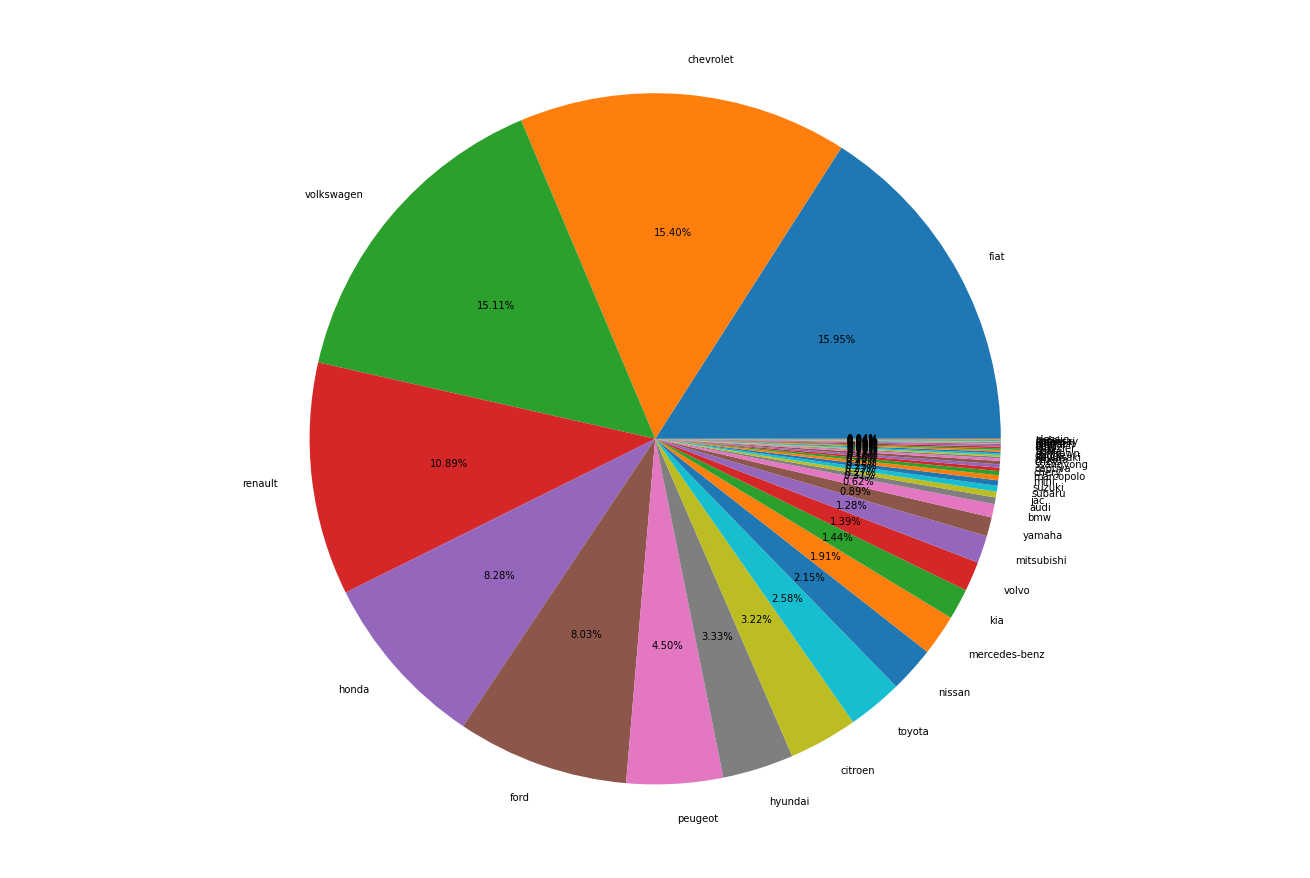

In [3]:
import pandas as pd 
dataset = pd.read_csv('./brand.csv')
value_counts = dict(dataset['label'].value_counts())
print(value_counts)

class2idx = {}
idx=0
for key in value_counts.keys():
    class2idx[key]=idx
    idx+=1

idx2class = {v: k for k, v in class2idx.items()}

dataset['label'].replace(class2idx, inplace=True)

from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
ax.axis('equal')
colours = value_counts.keys()
print('Classes',len(colours))
counts = value_counts.values()
ax.pie(counts, labels = colours,autopct='%1.2f%%')
plt.show()

In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.image as img
import torchvision.transforms as transforms
class VehicleBrandDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        image.resize()
        if self.transform is not None:
            image = self.transform(image)
        return image, label
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize((64,64))])
train, valid_data = train_test_split(dataset, stratify=dataset.label, test_size=0.2)
working_folder = "/home/anirban/ResearchTools/DL_Experiments/video_datasets/data/dataset2"
train_data = VehicleBrandDataset(train, working_folder,trans)
valid_data = VehicleBrandDataset(valid_data, working_folder,trans)

training images
torch.Size([3, 64, 64])


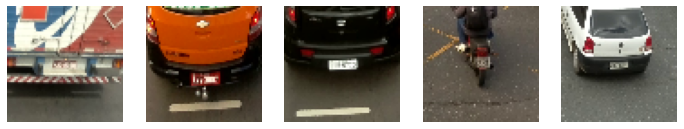

In [11]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
batch_size = 64
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class Lenet5Basic(nn.Module):
  def __init__(self, n_classes):
    super(Lenet5Basic, self).__init__()
    self.n_classes = n_classes

    self.classification = nn.Sequential(
        nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3, stride= 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2),
        nn.Conv2d(in_channels= 32, out_channels = 64, kernel_size= 3, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Conv2d(in_channels=64, out_channels= 128, kernel_size= 3, stride= 1, padding = 2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features= 46208, out_features= 128, bias = False),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = self.n_classes, bias = False),
    )

  def forward(self, x):
    logits = self.classification(x)
    print(logits.shape)
    prob_of_class = F.softmax(logits, dim = 1 )
    return logits#, prob_of_class



In [13]:
from torchsummary import summary
model = Lenet5Basic(42)
summary(model,(3,64,64))

torch.Size([2, 42])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 66, 66]             896
              ReLU-2           [-1, 32, 66, 66]               0
         MaxPool2d-3           [-1, 32, 33, 33]               0
            Conv2d-4           [-1, 64, 35, 35]          18,496
              ReLU-5           [-1, 64, 35, 35]               0
         MaxPool2d-6           [-1, 64, 17, 17]               0
            Conv2d-7          [-1, 128, 19, 19]          73,856
              ReLU-8          [-1, 128, 19, 19]               0
           Flatten-9                [-1, 46208]               0
           Linear-10                  [-1, 128]       5,914,624
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 42]           5,376
Total params: 6,013,248
Trainable params: 6,013,248
Non-trainable params: 0
-------

In [14]:
num_epochs = 50
num_classes = 42
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)


In [16]:
%%time
# keeping-track-of-losses 
device = torch.device('cpu')
train_losses = []
valid_losses = []

def get_prediction(logits):
    prob_of_class = F.softmax(logits, dim = 1 )
    _, predicted_class = torch.max(prob_of_class,1)
    return predicted_class

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    num_correct_train_data = 0
    n = 0
    # training-the-model
    model.train()
    batch_no =0
    for data, target in train_loader:
        print("Batch",batch_no)
        # move-tensors-to-GPU 
#         print(data,type(data))
#         print(target,type(target))
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        #accumulate number of correct labels
        pred_label = get_prediction(output.data)
        n += target.size(0)
        num_correct_train_data += (pred_label == target).sum().item()
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        batch_no +=1
    accuracy = float(num_correct_train_data)/n *100  
    print("Epoch: {} Training accuracy: {}".format(epoch,accuracy))
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print("Training Losses",train_losses)
    print("Valid Losses",valid_losses)

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 155
torch.Size([64, 42])
Batch 156
torch.Size([64, 42])
Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 172
torch.Size([64, 42])
Batch 173
torch.Size([64, 42])
Batch 174
torch.Size([64, 42])
Batch 175
torch.Size([64, 42])
Batch 176
torch.Size([64, 42])
Batch 177
torch.Size([64, 42])
Batch 178
torch.Size([64, 42])
Batch 179
torch.Size([64, 42])
Batch 180
torch.Size([64, 42])
Batch 181
torch.Size([64, 42])
Batch 182
torch.Size([64, 42])
Batch 183
torch.Size([64, 42])
Batch 184
torch.Size([64, 42])
Batch 185
torch.Size([64, 42])
Batch 186
torch.Size([64, 42])
Batch 18

Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
torch.Size([64, 42])
Batch 43
torch.Size([64, 42])
Batch 44
torch.Size([64, 42])
Batch 45
torch.Size([64, 42])
Batch 46
torch.Size([64, 42])
Batch 47
torch.Size([64, 42])
Batch 48
torch.Size([64, 42])
Batch 49
torch.Size([64, 42])
Batch 50
torch.Size([64, 42])
Batch 51
torch.Size([64, 42])
Batch 52
torch.Size([64, 42])
Batch 53
torch.Size([64, 42])
Batch 54
torch.Size([64, 42])
Batch 55
torch.Size([64, 42])
Batch 56
torch.Size([64, 42])
Batch 57
torch.Size([64, 42])
Batch 58
torch.Size([64, 42])
Batch 59
torch.Size([64, 42])
Batch 60
torch.Size([64, 42])
Batch 61
torch.Size([64, 42])
Batch 62
torch.Size([64, 42])
Batch 63
torch.Size([64, 42])
Batch 64
torch.Size([64, 42])
Batch 65
torch.Size([64, 42])
Batch 66
torch.Size([64, 42])
Batch 67
torch.Size([64, 42])
Batch 68
torch.Size([64, 42])
Batch 69
torch.Size([64, 42])
Batch 70
torch.Size([64, 42])
Batch 71
t

Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 309
torch.Size([64, 42])
Batch 310
torch.Size([64, 42])
Batch 311
torch.Size([64, 42])
Batch 312
torch.Size([64, 42])
Batch 313
torch.Size([64, 42])
Batch 314
torch.Size([64, 42])
Batch 315
torch.Size([64, 42])
Batch 316
torch.Size([64, 42])
Batch 317
torch.Size([64, 42])
Batch 318
torch.Size([64, 42])
Batch 319
torch.Size([64, 42])
Batch 320
torch.Size([23, 42])
Epoch: 3 Training accuracy: 96.17129200604789
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 4

Batch 189
torch.Size([64, 42])
Batch 190
torch.Size([64, 42])
Batch 191
torch.Size([64, 42])
Batch 192
torch.Size([64, 42])
Batch 193
torch.Size([64, 42])
Batch 194
torch.Size([64, 42])
Batch 195
torch.Size([64, 42])
Batch 196
torch.Size([64, 42])
Batch 197
torch.Size([64, 42])
Batch 198
torch.Size([64, 42])
Batch 199
torch.Size([64, 42])
Batch 200
torch.Size([64, 42])
Batch 201
torch.Size([64, 42])
Batch 202
torch.Size([64, 42])
Batch 203
torch.Size([64, 42])
Batch 204
torch.Size([64, 42])
Batch 205
torch.Size([64, 42])
Batch 206
torch.Size([64, 42])
Batch 207
torch.Size([64, 42])
Batch 208
torch.Size([64, 42])
Batch 209
torch.Size([64, 42])
Batch 210
torch.Size([64, 42])
Batch 211
torch.Size([64, 42])
Batch 212
torch.Size([64, 42])
Batch 213
torch.Size([64, 42])
Batch 214
torch.Size([64, 42])
Batch 215
torch.Size([64, 42])
Batch 216
torch.Size([64, 42])
Batch 217
torch.Size([64, 42])
Batch 218
torch.Size([64, 42])
Batch 219
torch.Size([64, 42])
Batch 220
torch.Size([64, 42])
Batch 22

Batch 71
torch.Size([64, 42])
Batch 72
torch.Size([64, 42])
Batch 73
torch.Size([64, 42])
Batch 74
torch.Size([64, 42])
Batch 75
torch.Size([64, 42])
Batch 76
torch.Size([64, 42])
Batch 77
torch.Size([64, 42])
Batch 78
torch.Size([64, 42])
Batch 79
torch.Size([64, 42])
Batch 80
torch.Size([64, 42])
Batch 81
torch.Size([64, 42])
Batch 82
torch.Size([64, 42])
Batch 83
torch.Size([64, 42])
Batch 84
torch.Size([64, 42])
Batch 85
torch.Size([64, 42])
Batch 86
torch.Size([64, 42])
Batch 87
torch.Size([64, 42])
Batch 88
torch.Size([64, 42])
Batch 89
torch.Size([64, 42])
Batch 90
torch.Size([64, 42])
Batch 91
torch.Size([64, 42])
Batch 92
torch.Size([64, 42])
Batch 93
torch.Size([64, 42])
Batch 94
torch.Size([64, 42])
Batch 95
torch.Size([64, 42])
Batch 96
torch.Size([64, 42])
Batch 97
torch.Size([64, 42])
Batch 98
torch.Size([64, 42])
Batch 99
torch.Size([64, 42])
Batch 100
torch.Size([64, 42])
Batch 101
torch.Size([64, 42])
Batch 102
torch.Size([64, 42])
Batch 103
torch.Size([64, 42])
Batch 

torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([6

Batch 218
torch.Size([64, 42])
Batch 219
torch.Size([64, 42])
Batch 220
torch.Size([64, 42])
Batch 221
torch.Size([64, 42])
Batch 222
torch.Size([64, 42])
Batch 223
torch.Size([64, 42])
Batch 224
torch.Size([64, 42])
Batch 225
torch.Size([64, 42])
Batch 226
torch.Size([64, 42])
Batch 227
torch.Size([64, 42])
Batch 228
torch.Size([64, 42])
Batch 229
torch.Size([64, 42])
Batch 230
torch.Size([64, 42])
Batch 231
torch.Size([64, 42])
Batch 232
torch.Size([64, 42])
Batch 233
torch.Size([64, 42])
Batch 234
torch.Size([64, 42])
Batch 235
torch.Size([64, 42])
Batch 236
torch.Size([64, 42])
Batch 237
torch.Size([64, 42])
Batch 238
torch.Size([64, 42])
Batch 239
torch.Size([64, 42])
Batch 240
torch.Size([64, 42])
Batch 241
torch.Size([64, 42])
Batch 242
torch.Size([64, 42])
Batch 243
torch.Size([64, 42])
Batch 244
torch.Size([64, 42])
Batch 245
torch.Size([64, 42])
Batch 246
torch.Size([64, 42])
Batch 247
torch.Size([64, 42])
Batch 248
torch.Size([64, 42])
Batch 249
torch.Size([64, 42])
Batch 25

Batch 98
torch.Size([64, 42])
Batch 99
torch.Size([64, 42])
Batch 100
torch.Size([64, 42])
Batch 101
torch.Size([64, 42])
Batch 102
torch.Size([64, 42])
Batch 103
torch.Size([64, 42])
Batch 104
torch.Size([64, 42])
Batch 105
torch.Size([64, 42])
Batch 106
torch.Size([64, 42])
Batch 107
torch.Size([64, 42])
Batch 108
torch.Size([64, 42])
Batch 109
torch.Size([64, 42])
Batch 110
torch.Size([64, 42])
Batch 111
torch.Size([64, 42])
Batch 112
torch.Size([64, 42])
Batch 113
torch.Size([64, 42])
Batch 114
torch.Size([64, 42])
Batch 115
torch.Size([64, 42])
Batch 116
torch.Size([64, 42])
Batch 117
torch.Size([64, 42])
Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130


torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([6, 42])
Epoch: 7 	Training Loss: 0.039914 	Validation Loss: 0.349121
Training Losses [0.8408120284188126, 0.30398299873517687, 0.12341962512127395, 0.064054090414304, 0.03818231507454803, 0.02909946755764514, 0.039914446989513054]
Valid Losses [0.5501865910404695, 0.39089548659892087, 0.31981863733199345, 0.33435976915744614, 0.35287677381264715, 0.3336731430449804, 0.3491207214244585]
Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch

Batch 241
torch.Size([64, 42])
Batch 242
torch.Size([64, 42])
Batch 243
torch.Size([64, 42])
Batch 244
torch.Size([64, 42])
Batch 245
torch.Size([64, 42])
Batch 246
torch.Size([64, 42])
Batch 247
torch.Size([64, 42])
Batch 248
torch.Size([64, 42])
Batch 249
torch.Size([64, 42])
Batch 250
torch.Size([64, 42])
Batch 251
torch.Size([64, 42])
Batch 252
torch.Size([64, 42])
Batch 253
torch.Size([64, 42])
Batch 254
torch.Size([64, 42])
Batch 255
torch.Size([64, 42])
Batch 256
torch.Size([64, 42])
Batch 257
torch.Size([64, 42])
Batch 258
torch.Size([64, 42])
Batch 259
torch.Size([64, 42])
Batch 260
torch.Size([64, 42])
Batch 261
torch.Size([64, 42])
Batch 262
torch.Size([64, 42])
Batch 263
torch.Size([64, 42])
Batch 264
torch.Size([64, 42])
Batch 265
torch.Size([64, 42])
Batch 266
torch.Size([64, 42])
Batch 267
torch.Size([64, 42])
Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 27

Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 15

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 150
torch.Size([64, 42])
Batch 151
torch.Size([64, 42])
Batch 152
torch.Size([64, 42])
Batch 153
torch.Size([64, 42])
Batch 154
torch.Size([64, 42])
Batch 155
torch.Size([64, 42])
Batch 156
torch.Size([64, 42])
Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 172
torch.Size([64, 42])
Batch 173
torch.Size([64, 42])
Batch 174
torch.Size([64, 42])
Batch 17

Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
torch.Size([64, 42])
Batch 43
torch.Size([64, 42])
Batch 44
torch.Size([64, 42])
Batch 45
torch.Size([64, 42])
Batch 46
torch.Size([64, 42])
Batch 47
t

Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 309
torch.Size([64, 42])
Batch 310
torch.Size([64, 42])
Batch 311
torch.Size([64, 42])
Batch 312
torch.Size([64, 42])
Batch 313
torch.Size([64, 42])
Batch 31

Batch 154
torch.Size([64, 42])
Batch 155
torch.Size([64, 42])
Batch 156
torch.Size([64, 42])
Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 172
torch.Size([64, 42])
Batch 173
torch.Size([64, 42])
Batch 174
torch.Size([64, 42])
Batch 175
torch.Size([64, 42])
Batch 176
torch.Size([64, 42])
Batch 177
torch.Size([64, 42])
Batch 178
torch.Size([64, 42])
Batch 179
torch.Size([64, 42])
Batch 180
torch.Size([64, 42])
Batch 181
torch.Size([64, 42])
Batch 182
torch.Size([64, 42])
Batch 183
torch.Size([64, 42])
Batch 184
torch.Size([64, 42])
Batch 185
torch.Size([64, 42])
Batch 18

Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
torch.Size([64, 42])
Batch 43
torch.Size([64, 42])
Batch 44
torch.Size([64, 42])
Batch 45
torch.Size([64, 42])
Batch 46
torch.Size([64, 42])
Batch 47
torch.Size([64, 42])
Batch 48
torch.Size([64, 42])
Batch 49
torch.Size([64, 42])
Batch 50
torch.Size([64, 42])
Batch 51
torch.Size([64, 42])
Batch 52
torch.Size([64, 42])
Batch 53
torch.Size([64, 42])
Batch 54
torch.Size([64, 42])
Batch 55
t

Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 309
torch.Size([64, 42])
Batch 310
torch.Size([64, 42])
Batch 311
torch.Size([64, 42])
Batch 312
torch.Size([64, 42])
Batch 313
torch.Size([64, 42])
Batch 314
torch.Size([64, 42])
Batch 315
torch.Size([64, 42])
Batch 316
torch.Size([64, 42])
Batch 317
torch.Size([64, 42])
Batch 318
torch.Size([64, 42])
Batch 319
torch.Size([64, 42])
Batch 320
torch.Size([23, 42])
Epoch: 1

Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 172
torch.Size([64, 42])
Batch 173
torch.Size([64, 42])
Batch 174
torch.Size([64, 42])
Batch 175
torch.Size([64, 42])
Batch 176
torch.Size([64, 42])
Batch 177
torch.Size([64, 42])
Batch 178
torch.Size([64, 42])
Batch 179
torch.Size([64, 42])
Batch 180
torch.Size([64, 42])
Batch 181
torch.Size([64, 42])
Batch 182
torch.Size([64, 42])
Batch 183
torch.Size([64, 42])
Batch 184
torch.Size([64, 42])
Batch 185
torch.Size([64, 42])
Batch 186
torch.Size([64, 42])
Batch 187
torch.Size([64, 42])
Batch 188
torch.Size([64, 42])
Batch 189
torch.Size([64, 42])
Batch 19

Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
torch.Size([64, 42])
Batch 43
torch.Size([64, 42])
Batch 44
torch.Size([64, 42])
Batch 45
torch.Size([64, 42])
Batch 46
torch.Size([64, 42])
Batch 47
torch.Size([64, 42])
Batch 48
torch.Size([64, 42])
Batch 49
torch.Size([64, 42])
Batch 50
torch.Size([64, 42])
Batch 51
torch.Size([64, 42])
Batch 52
torch.Size([64, 42])
Batch 53
torch.Size([64, 42])
Batch 54
torch.Size([64, 42])
Batch 55
torch.Size([64, 42])
Batch 56
t

Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 309
torch.Size([64, 42])
Batch 310
torch.Size([64, 42])
Batch 311
torch.Size([64, 42])
Batch 312
torch.Size([64, 42])
Batch 313
torch.Size([64, 42])
Batch 314
torch.Size([64, 42])
Batch 315
torch.Size([64, 42])
Batch 316
torch.Size([64, 42])
Batch 317
torch.Size([64, 42])
Batch 318
torch.Size([64, 42])
Batch 319
torch.Size([64, 42])
Batch 320
torch.Size([23, 42])
Epoch: 16 Training accuracy: 99.3561917

Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 172
torch.Size([64, 42])
Batch 173
torch.Size([64, 42])
Batch 174
torch.Size([64, 42])
Batch 175
torch.Size([64, 42])
Batch 176
torch.Size([64, 42])
Batch 177
torch.Size([64, 42])
Batch 178
torch.Size([64, 42])
Batch 179
torch.Size([64, 42])
Batch 180
torch.Size([64, 42])
Batch 181
torch.Size([64, 42])
Batch 182
torch.Size([64, 42])
Batch 183
torch.Size([64, 42])
Batch 184
torch.Size([64, 42])
Batch 185
torch.Size([64, 42])
Batch 186
torch.Size([64, 42])
Batch 187
torch.Size([64, 42])
Batch 188
torch.Size([64, 42])
Batch 18

Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
torch.Size([64, 42])
Batch 43
torch.Size([64, 42])
Batch 44
torch.Size([64, 42])
Batch 45
torch.Size([64, 42])
Batch 46
torch.Size([64, 42])
Batch 47
torch.Size([64, 42])
Batch 48
torch.Size([64, 42])
Batch 49
torch.Size([64, 42])
Batch 50
torch.Size([64, 42])
Batch 51
torch.Size([64, 42])
Batch 52
torch.Size([64, 42])
Batch 53
t

Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 309
torch.Size([64, 42])
Batch 310
torch.Size([64, 42])
Batch 311
torch.Size([64, 42])
Batch 312
torch.Size([64, 42])
Batch 313
torch.Size([64, 42])
Batch 314
torch.Size([64, 42])
Batch 315
torch.Size([64, 42])
Batch 316
torch.Size([64, 42])
Batch 317
torch.Size([64, 42])
Batch 318
torch.Size([64, 42])
Batch 31

Batch 151
torch.Size([64, 42])
Batch 152
torch.Size([64, 42])
Batch 153
torch.Size([64, 42])
Batch 154
torch.Size([64, 42])
Batch 155
torch.Size([64, 42])
Batch 156
torch.Size([64, 42])
Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 172
torch.Size([64, 42])
Batch 173
torch.Size([64, 42])
Batch 174
torch.Size([64, 42])
Batch 175
torch.Size([64, 42])
Batch 176
torch.Size([64, 42])
Batch 177
torch.Size([64, 42])
Batch 178
torch.Size([64, 42])
Batch 179
torch.Size([64, 42])
Batch 180
torch.Size([64, 42])
Batch 181
torch.Size([64, 42])
Batch 182
torch.Size([64, 42])
Batch 18

Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
torch.Size([64, 42])
Batch 43
torch.Size([64, 42])
Batch 44
t

Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 309
torch.Size([64, 42])
Batch 310
torch.Size([64, 42])
Batch 31

Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 150
torch.Size([64, 42])
Batch 151
torch.Size([64, 42])
Batch 152
torch.Size([64, 42])
Batch 153
torch.Size([64, 42])
Batch 154
torch.Size([64, 42])
Batch 155
torch.Size([64, 42])
Batch 156
torch.Size([64, 42])
Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 17

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 150
torch.Size([64, 42])
Batch 151
torch.Size([64, 42])
Batch 152
torch.Size([64, 42])
Batch 153
torch.Size([64, 42])
Batch 154
torch.Size([64, 42])
Batch 155
torch.Size([64, 42])
Batch 156
torch.Size([64, 42])
Batch 157
torch.Size([64, 42])
Batch 15

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 150
torch.Size([64, 42])
Batch 151
torch.Size([64, 42])
Batch 152
torch.Size([64, 42])
Batch 153
torch.Size([64, 42])
Batch 154
torch.Size([64, 42])
Batch 155
torch.Size([64, 42])
Batch 15

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 150
torch.Size([64, 42])
Batch 151
torch.Size([64, 42])
Batch 152
torch.Size([64, 42])
Batch 15

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 15

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 116
torch.Size([64, 42])
Batch 117
torch.Size([64, 42])
Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 14

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 113
torch.Size([64, 42])
Batch 114
torch.Size([64, 42])
Batch 115
torch.Size([64, 42])
Batch 116
torch.Size([64, 42])
Batch 117
torch.Size([64, 42])
Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 14

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 110
torch.Size([64, 42])
Batch 111
torch.Size([64, 42])
Batch 112
torch.Size([64, 42])
Batch 113
torch.Size([64, 42])
Batch 114
torch.Size([64, 42])
Batch 115
torch.Size([64, 42])
Batch 116
torch.Size([64, 42])
Batch 117
torch.Size([64, 42])
Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 14

torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([6, 42])
Epoch: 35 	Training Loss: 0.000005 	Validation Loss: 0.474740
Training Losses [0.8408120284188126, 0.30398299873517687, 0.12341962512127395, 0.064054090414304, 0.03818231507454803, 0.02909946755764514, 0.039914446989513054, 0.02908559717503769, 0.026395169473196638, 0.01847347285819639, 0.026310506835634382, 0.022518977412515816, 0.03203616390480885, 0.01801260837326069, 0.01389921697421053, 0.019895269270701375, 0.01824393953661253, 0.025591887714184254, 0.01059480440821814, 0.013651887388937203, 0.016092393392165998, 0.013316185893947874, 0.021154123299074578, 0.023957620395997446, 0.009326680064488386, 0.0015818563150922652, 0.0003143399172672138, 3.9072235502371586e-05, 1.915542082220374e-05, 1.4376165311636839e-05, 1.1363907119764166e-05, 9.199869637311865e-06, 7.547396277025895e-06, 6.262158839961666e-06, 5.233397738662469e-06]
Valid Losses [0.5501865910404695, 0.39089548659892087, 0.31981863733199

Batch 215
torch.Size([64, 42])
Batch 216
torch.Size([64, 42])
Batch 217
torch.Size([64, 42])
Batch 218
torch.Size([64, 42])
Batch 219
torch.Size([64, 42])
Batch 220
torch.Size([64, 42])
Batch 221
torch.Size([64, 42])
Batch 222
torch.Size([64, 42])
Batch 223
torch.Size([64, 42])
Batch 224
torch.Size([64, 42])
Batch 225
torch.Size([64, 42])
Batch 226
torch.Size([64, 42])
Batch 227
torch.Size([64, 42])
Batch 228
torch.Size([64, 42])
Batch 229
torch.Size([64, 42])
Batch 230
torch.Size([64, 42])
Batch 231
torch.Size([64, 42])
Batch 232
torch.Size([64, 42])
Batch 233
torch.Size([64, 42])
Batch 234
torch.Size([64, 42])
Batch 235
torch.Size([64, 42])
Batch 236
torch.Size([64, 42])
Batch 237
torch.Size([64, 42])
Batch 238
torch.Size([64, 42])
Batch 239
torch.Size([64, 42])
Batch 240
torch.Size([64, 42])
Batch 241
torch.Size([64, 42])
Batch 242
torch.Size([64, 42])
Batch 243
torch.Size([64, 42])
Batch 244
torch.Size([64, 42])
Batch 245
torch.Size([64, 42])
Batch 246
torch.Size([64, 42])
Batch 24

Batch 53
torch.Size([64, 42])
Batch 54
torch.Size([64, 42])
Batch 55
torch.Size([64, 42])
Batch 56
torch.Size([64, 42])
Batch 57
torch.Size([64, 42])
Batch 58
torch.Size([64, 42])
Batch 59
torch.Size([64, 42])
Batch 60
torch.Size([64, 42])
Batch 61
torch.Size([64, 42])
Batch 62
torch.Size([64, 42])
Batch 63
torch.Size([64, 42])
Batch 64
torch.Size([64, 42])
Batch 65
torch.Size([64, 42])
Batch 66
torch.Size([64, 42])
Batch 67
torch.Size([64, 42])
Batch 68
torch.Size([64, 42])
Batch 69
torch.Size([64, 42])
Batch 70
torch.Size([64, 42])
Batch 71
torch.Size([64, 42])
Batch 72
torch.Size([64, 42])
Batch 73
torch.Size([64, 42])
Batch 74
torch.Size([64, 42])
Batch 75
torch.Size([64, 42])
Batch 76
torch.Size([64, 42])
Batch 77
torch.Size([64, 42])
Batch 78
torch.Size([64, 42])
Batch 79
torch.Size([64, 42])
Batch 80
torch.Size([64, 42])
Batch 81
torch.Size([64, 42])
Batch 82
torch.Size([64, 42])
Batch 83
torch.Size([64, 42])
Batch 84
torch.Size([64, 42])
Batch 85
torch.Size([64, 42])
Batch 86
t

Batch 319
torch.Size([64, 42])
Batch 320
torch.Size([23, 42])
Epoch: 37 Training accuracy: 100.0
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])


Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 161
torch.Size([64, 42])
Batch 162
torch.Size([64, 42])
Batch 163
torch.Size([64, 42])
Batch 164
torch.Size([64, 42])
Batch 165
torch.Size([64, 42])
Batch 166
torch.Size([64, 42])
Batch 167
torch.Size([64, 42])
Batch 168
torch.Size([64, 42])
Batch 169
torch.Size([64, 42])
Batch 170
torch.Size([64, 42])
Batch 171
torch.Size([64, 42])
Batch 172
torch.Size([64, 42])
Batch 173
torch.Size([64, 42])
Batch 174
torch.Size([64, 42])
Batch 175
torch.Size([64, 42])
Batch 176
torch.Size([64, 42])
Batch 177
torch.Size([64, 42])
Batch 178
torch.Size([64, 42])
Batch 179
torch.Size([64, 42])
Batch 180
torch.Size([64, 42])
Batch 181
torch.Size([64, 42])
Batch 182
torch.Size([64, 42])
Batch 183
torch.Size([64, 42])
Batch 184
torch.Size([64, 42])
Batch 185
torch.Size([64, 42])
Batch 186
torch.Size([64, 42])
Batch 187
torch.Size([64, 42])
Batch 188
torch.Size([64, 42])
Batch 18

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 103
torch.Size([64, 42])
Batch 104
torch.Size([64, 42])
Batch 105
torch.Size([64, 42])
Batch 106
torch.Size([64, 42])
Batch 107
torch.Size([64, 42])
Batch 108
torch.Size([64, 42])
Batch 109
torch.Size([64, 42])
Batch 110
torch.Size([64, 42])
Batch 111
torch.Size([64, 42])
Batch 112
torch.Size([64, 42])
Batch 113
torch.Size([64, 42])
Batch 114
torch.Size([64, 42])
Batch 115
torch.Size([64, 42])
Batch 116
torch.Size([64, 42])
Batch 117
torch.Size([64, 42])
Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 13

torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([6, 42])
Epoch: 40 	Training Loss: 0.000002 	Validation Loss: 0.495190
Training Losses [0.8408120284188126, 0.30398299873517687, 0.12341962512127395, 0.064054090414304, 0.03818231507454803, 0.02909946755764514, 0.039914446989513054, 0.02908559717503769, 0.026395169473196638, 0.01847347285819639, 0.026310506835634382, 0.022518977412515816, 0.03203616390480885, 0.01801260837326069, 0.01389921697421053, 0.019895269270701375, 0.01824393953661253, 0.025591887714184254, 0.01059480440821814, 0.013651887388937203, 0.016092393392165998, 0.013316185893947874, 0.021154123299074578, 0.023957620395997446, 0.009326680064488386, 0.0015818563150922652, 0.0003143399172672138, 3.9072235502371586e-05, 1.915542082220374e-05, 1

Batch 201
torch.Size([64, 42])
Batch 202
torch.Size([64, 42])
Batch 203
torch.Size([64, 42])
Batch 204
torch.Size([64, 42])
Batch 205
torch.Size([64, 42])
Batch 206
torch.Size([64, 42])
Batch 207
torch.Size([64, 42])
Batch 208
torch.Size([64, 42])
Batch 209
torch.Size([64, 42])
Batch 210
torch.Size([64, 42])
Batch 211
torch.Size([64, 42])
Batch 212
torch.Size([64, 42])
Batch 213
torch.Size([64, 42])
Batch 214
torch.Size([64, 42])
Batch 215
torch.Size([64, 42])
Batch 216
torch.Size([64, 42])
Batch 217
torch.Size([64, 42])
Batch 218
torch.Size([64, 42])
Batch 219
torch.Size([64, 42])
Batch 220
torch.Size([64, 42])
Batch 221
torch.Size([64, 42])
Batch 222
torch.Size([64, 42])
Batch 223
torch.Size([64, 42])
Batch 224
torch.Size([64, 42])
Batch 225
torch.Size([64, 42])
Batch 226
torch.Size([64, 42])
Batch 227
torch.Size([64, 42])
Batch 228
torch.Size([64, 42])
Batch 229
torch.Size([64, 42])
Batch 230
torch.Size([64, 42])
Batch 231
torch.Size([64, 42])
Batch 232
torch.Size([64, 42])
Batch 23

Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
torch.Size([64, 42])
Batch 43
torch.Size([64, 42])
Batch 44
torch.Size([64, 42])
Batch 45
torch.Size([64, 42])
Batch 46
torch.Size([64, 42])
Batch 47
torch.Size([64, 42])
Batch 48
torch.Size([64, 42])
Batch 49
torch.Size([64, 42])
Batch 50
torch.Size([64, 42])
Batch 51
torch.Size([64, 42])
Batch 52
torch.Size([64, 42])
Batch 53
torch.Size([64, 42])
Batch 54
torch.Size([64, 42])
Batch 55
torch.Size([64, 42])
Batch 56
torch.Size([64, 42])
Batch 57
torch.Size([64, 42])
Batch 58
torch.Size([64, 42])
Batch 59
torch.Size([64, 42])
Batch 60
torch.Size([64, 42])
Batch 61
torch.Size([64, 42])
Batch 62
torch.Size([64, 42])
Batch 63
torch.Size([64, 42])
Batch 64
t

Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 309
torch.Size([64, 42])
Batch 310
torch.Size([64, 42])
Batch 311
torch.Size([64, 42])
Batch 312
torch.Size([64, 42])
Batch 313
torch.Size([64, 42])
Batch 314
torch.Size([64, 42])
Batch 315
torch.Size([64, 42])
Batch 316
torch.Size([64, 42])
Batch 317
torch.Size([64, 42])
Batch 318
torch.Size([64, 42])
Batch 319
torch.Size([64, 42])
Batch 320
torch.Size([23, 42])
Epoch: 42 Training accuracy: 100.0
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])


Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 133
torch.Size([64, 42])
Batch 134
torch.Size([64, 42])
Batch 135
torch.Size([64, 42])
Batch 136
torch.Size([64, 42])
Batch 137
torch.Size([64, 42])
Batch 138
torch.Size([64, 42])
Batch 139
torch.Size([64, 42])
Batch 140
torch.Size([64, 42])
Batch 141
torch.Size([64, 42])
Batch 142
torch.Size([64, 42])
Batch 143
torch.Size([64, 42])
Batch 144
torch.Size([64, 42])
Batch 145
torch.Size([64, 42])
Batch 146
torch.Size([64, 42])
Batch 147
torch.Size([64, 42])
Batch 148
torch.Size([64, 42])
Batch 149
torch.Size([64, 42])
Batch 150
torch.Size([64, 42])
Batch 151
torch.Size([64, 42])
Batch 152
torch.Size([64, 42])
Batch 153
torch.Size([64, 42])
Batch 154
torch.Size([64, 42])
Batch 155
torch.Size([64, 42])
Batch 156
torch.Size([64, 42])
Batch 157
torch.Size([64, 42])
Batch 158
torch.Size([64, 42])
Batch 159
torch.Size([64, 42])
Batch 160
torch.Size([64, 42])
Batch 16

Batch 0
torch.Size([64, 42])
Batch 1
torch.Size([64, 42])
Batch 2
torch.Size([64, 42])
Batch 3
torch.Size([64, 42])
Batch 4
torch.Size([64, 42])
Batch 5
torch.Size([64, 42])
Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size(

Batch 268
torch.Size([64, 42])
Batch 269
torch.Size([64, 42])
Batch 270
torch.Size([64, 42])
Batch 271
torch.Size([64, 42])
Batch 272
torch.Size([64, 42])
Batch 273
torch.Size([64, 42])
Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 30

Batch 96
torch.Size([64, 42])
Batch 97
torch.Size([64, 42])
Batch 98
torch.Size([64, 42])
Batch 99
torch.Size([64, 42])
Batch 100
torch.Size([64, 42])
Batch 101
torch.Size([64, 42])
Batch 102
torch.Size([64, 42])
Batch 103
torch.Size([64, 42])
Batch 104
torch.Size([64, 42])
Batch 105
torch.Size([64, 42])
Batch 106
torch.Size([64, 42])
Batch 107
torch.Size([64, 42])
Batch 108
torch.Size([64, 42])
Batch 109
torch.Size([64, 42])
Batch 110
torch.Size([64, 42])
Batch 111
torch.Size([64, 42])
Batch 112
torch.Size([64, 42])
Batch 113
torch.Size([64, 42])
Batch 114
torch.Size([64, 42])
Batch 115
torch.Size([64, 42])
Batch 116
torch.Size([64, 42])
Batch 117
torch.Size([64, 42])
Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
to

torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([6, 42])
Epoch: 45 	Training Loss: 0.000001 	Validation Loss: 0.516043
Training Losses [0.8408120284188126, 0.30398299873517687, 0.12341962512127395, 0.064054090414304, 0.03818231507454803, 0.02909946755764514, 0.039914446989513054, 0.02908559717503769, 0.026395169473196638, 0.01847347285819639, 0.026310506835634382, 0.022518977412515816, 0.03203616390480885, 0.01801260837326069, 0.01389921697421053, 0.019895269270701375, 0.01824393953661253, 0.025591887714184254, 0.01059480440821814, 0.01365188738893

Batch 187
torch.Size([64, 42])
Batch 188
torch.Size([64, 42])
Batch 189
torch.Size([64, 42])
Batch 190
torch.Size([64, 42])
Batch 191
torch.Size([64, 42])
Batch 192
torch.Size([64, 42])
Batch 193
torch.Size([64, 42])
Batch 194
torch.Size([64, 42])
Batch 195
torch.Size([64, 42])
Batch 196
torch.Size([64, 42])
Batch 197
torch.Size([64, 42])
Batch 198
torch.Size([64, 42])
Batch 199
torch.Size([64, 42])
Batch 200
torch.Size([64, 42])
Batch 201
torch.Size([64, 42])
Batch 202
torch.Size([64, 42])
Batch 203
torch.Size([64, 42])
Batch 204
torch.Size([64, 42])
Batch 205
torch.Size([64, 42])
Batch 206
torch.Size([64, 42])
Batch 207
torch.Size([64, 42])
Batch 208
torch.Size([64, 42])
Batch 209
torch.Size([64, 42])
Batch 210
torch.Size([64, 42])
Batch 211
torch.Size([64, 42])
Batch 212
torch.Size([64, 42])
Batch 213
torch.Size([64, 42])
Batch 214
torch.Size([64, 42])
Batch 215
torch.Size([64, 42])
Batch 216
torch.Size([64, 42])
Batch 217
torch.Size([64, 42])
Batch 218
torch.Size([64, 42])
Batch 21

Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch.Size([64, 42])
Batch 40
torch.Size([64, 42])
Batch 41
torch.Size([64, 42])
Batch 42
to

Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 306
torch.Size([64, 42])
Batch 307
torch.Size([64, 42])
Batch 308
torch.Size([64, 42])
Batch 30

Batch 101
torch.Size([64, 42])
Batch 102
torch.Size([64, 42])
Batch 103
torch.Size([64, 42])
Batch 104
torch.Size([64, 42])
Batch 105
torch.Size([64, 42])
Batch 106
torch.Size([64, 42])
Batch 107
torch.Size([64, 42])
Batch 108
torch.Size([64, 42])
Batch 109
torch.Size([64, 42])
Batch 110
torch.Size([64, 42])
Batch 111
torch.Size([64, 42])
Batch 112
torch.Size([64, 42])
Batch 113
torch.Size([64, 42])
Batch 114
torch.Size([64, 42])
Batch 115
torch.Size([64, 42])
Batch 116
torch.Size([64, 42])
Batch 117
torch.Size([64, 42])
Batch 118
torch.Size([64, 42])
Batch 119
torch.Size([64, 42])
Batch 120
torch.Size([64, 42])
Batch 121
torch.Size([64, 42])
Batch 122
torch.Size([64, 42])
Batch 123
torch.Size([64, 42])
Batch 124
torch.Size([64, 42])
Batch 125
torch.Size([64, 42])
Batch 126
torch.Size([64, 42])
Batch 127
torch.Size([64, 42])
Batch 128
torch.Size([64, 42])
Batch 129
torch.Size([64, 42])
Batch 130
torch.Size([64, 42])
Batch 131
torch.Size([64, 42])
Batch 132
torch.Size([64, 42])
Batch 13

torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([64, 42])
torch.Size([6, 42])
Epoch: 48 	Training Loss: 0.000001 	Validation Loss: 0.528544
Training Losses [0.8408120284188126, 0.30398299873517687, 0.12341962512127395, 0.064054090414304, 0.03818231507454803, 0.02909946755764514, 0.039914446989513054, 0.02908559717503769, 0.026395169473196638, 0.01847347285819639, 0.026310506835634382, 0.022518977412515816, 0.03203616390480885, 0.01801260837326069, 0.01389921697421053, 0.019895269270701375, 0.01824393953661253, 0.025591887714184254, 0.01059480440821814, 0.013651887388937203, 0.016092393392165998, 0.013316185893947874, 0.021154123299074578, 0.023957620395997446, 0.009326680064488386, 0.0015818563150922652, 0.000314

Batch 188
torch.Size([64, 42])
Batch 189
torch.Size([64, 42])
Batch 190
torch.Size([64, 42])
Batch 191
torch.Size([64, 42])
Batch 192
torch.Size([64, 42])
Batch 193
torch.Size([64, 42])
Batch 194
torch.Size([64, 42])
Batch 195
torch.Size([64, 42])
Batch 196
torch.Size([64, 42])
Batch 197
torch.Size([64, 42])
Batch 198
torch.Size([64, 42])
Batch 199
torch.Size([64, 42])
Batch 200
torch.Size([64, 42])
Batch 201
torch.Size([64, 42])
Batch 202
torch.Size([64, 42])
Batch 203
torch.Size([64, 42])
Batch 204
torch.Size([64, 42])
Batch 205
torch.Size([64, 42])
Batch 206
torch.Size([64, 42])
Batch 207
torch.Size([64, 42])
Batch 208
torch.Size([64, 42])
Batch 209
torch.Size([64, 42])
Batch 210
torch.Size([64, 42])
Batch 211
torch.Size([64, 42])
Batch 212
torch.Size([64, 42])
Batch 213
torch.Size([64, 42])
Batch 214
torch.Size([64, 42])
Batch 215
torch.Size([64, 42])
Batch 216
torch.Size([64, 42])
Batch 217
torch.Size([64, 42])
Batch 218
torch.Size([64, 42])
Batch 219
torch.Size([64, 42])
Batch 22

Batch 6
torch.Size([64, 42])
Batch 7
torch.Size([64, 42])
Batch 8
torch.Size([64, 42])
Batch 9
torch.Size([64, 42])
Batch 10
torch.Size([64, 42])
Batch 11
torch.Size([64, 42])
Batch 12
torch.Size([64, 42])
Batch 13
torch.Size([64, 42])
Batch 14
torch.Size([64, 42])
Batch 15
torch.Size([64, 42])
Batch 16
torch.Size([64, 42])
Batch 17
torch.Size([64, 42])
Batch 18
torch.Size([64, 42])
Batch 19
torch.Size([64, 42])
Batch 20
torch.Size([64, 42])
Batch 21
torch.Size([64, 42])
Batch 22
torch.Size([64, 42])
Batch 23
torch.Size([64, 42])
Batch 24
torch.Size([64, 42])
Batch 25
torch.Size([64, 42])
Batch 26
torch.Size([64, 42])
Batch 27
torch.Size([64, 42])
Batch 28
torch.Size([64, 42])
Batch 29
torch.Size([64, 42])
Batch 30
torch.Size([64, 42])
Batch 31
torch.Size([64, 42])
Batch 32
torch.Size([64, 42])
Batch 33
torch.Size([64, 42])
Batch 34
torch.Size([64, 42])
Batch 35
torch.Size([64, 42])
Batch 36
torch.Size([64, 42])
Batch 37
torch.Size([64, 42])
Batch 38
torch.Size([64, 42])
Batch 39
torch

Batch 274
torch.Size([64, 42])
Batch 275
torch.Size([64, 42])
Batch 276
torch.Size([64, 42])
Batch 277
torch.Size([64, 42])
Batch 278
torch.Size([64, 42])
Batch 279
torch.Size([64, 42])
Batch 280
torch.Size([64, 42])
Batch 281
torch.Size([64, 42])
Batch 282
torch.Size([64, 42])
Batch 283
torch.Size([64, 42])
Batch 284
torch.Size([64, 42])
Batch 285
torch.Size([64, 42])
Batch 286
torch.Size([64, 42])
Batch 287
torch.Size([64, 42])
Batch 288
torch.Size([64, 42])
Batch 289
torch.Size([64, 42])
Batch 290
torch.Size([64, 42])
Batch 291
torch.Size([64, 42])
Batch 292
torch.Size([64, 42])
Batch 293
torch.Size([64, 42])
Batch 294
torch.Size([64, 42])
Batch 295
torch.Size([64, 42])
Batch 296
torch.Size([64, 42])
Batch 297
torch.Size([64, 42])
Batch 298
torch.Size([64, 42])
Batch 299
torch.Size([64, 42])
Batch 300
torch.Size([64, 42])
Batch 301
torch.Size([64, 42])
Batch 302
torch.Size([64, 42])
Batch 303
torch.Size([64, 42])
Batch 304
torch.Size([64, 42])
Batch 305
torch.Size([64, 42])
Batch 30

In [35]:
def save_ckp(model, optimizer,epoch,file_prefix):
    checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
    filename=file_prefix+"_"+str(epoch)+".pth"
    torch.save(checkpoint, filename)
file_prefix = "./models/brand/brand_checkpoint"
save_ckp(model,optimizer,epoch,file_prefix)

[0.8408120284188126, 0.30398299873517687, 0.12341962512127395, 0.064054090414304, 0.03818231507454803, 0.02909946755764514, 0.039914446989513054, 0.02908559717503769, 0.026395169473196638, 0.01847347285819639, 0.026310506835634382, 0.022518977412515816, 0.03203616390480885, 0.01801260837326069, 0.01389921697421053, 0.019895269270701375, 0.01824393953661253, 0.025591887714184254, 0.01059480440821814, 0.013651887388937203, 0.016092393392165998, 0.013316185893947874, 0.021154123299074578, 0.023957620395997446, 0.009326680064488386, 0.0015818563150922652, 0.0003143399172672138, 3.9072235502371586e-05, 1.915542082220374e-05, 1.4376165311636839e-05, 1.1363907119764166e-05, 9.199869637311865e-06, 7.547396277025895e-06, 6.262158839961666e-06, 5.233397738662469e-06, 4.392357203649436e-06, 3.6933582175719666e-06, 3.1191167662972806e-06, 2.6349119236109586e-06, 2.2305852861424494e-06, 1.887815613831307e-06, 1.5976162205793004e-06, 1.3538145446722916e-06, 1.1480633083533743e-06, 9.732878730385275e

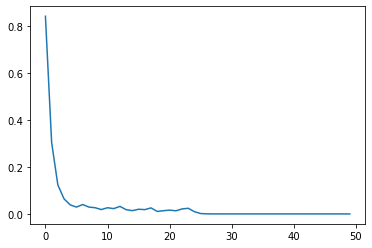

In [19]:
train_loss_values =  [0.8408120284188126, 0.30398299873517687, 0.12341962512127395, 0.064054090414304, 0.03818231507454803, 0.02909946755764514, 0.039914446989513054, 0.02908559717503769, 0.026395169473196638, 0.01847347285819639, 0.026310506835634382, 0.022518977412515816, 0.03203616390480885, 0.01801260837326069, 0.01389921697421053, 0.019895269270701375, 0.01824393953661253, 0.025591887714184254, 0.01059480440821814, 0.013651887388937203, 0.016092393392165998, 0.013316185893947874, 0.021154123299074578, 0.023957620395997446, 0.009326680064488386, 0.0015818563150922652, 0.0003143399172672138, 3.9072235502371586e-05, 1.915542082220374e-05, 1.4376165311636839e-05, 1.1363907119764166e-05, 9.199869637311865e-06, 7.547396277025895e-06, 6.262158839961666e-06, 5.233397738662469e-06, 4.392357203649436e-06, 3.6933582175719666e-06, 3.1191167662972806e-06, 2.6349119236109586e-06, 2.2305852861424494e-06, 1.887815613831307e-06, 1.5976162205793004e-06, 1.3538145446722916e-06, 1.1480633083533743e-06, 9.732878730385275e-07, 8.246165198986599e-07, 7.000612104837209e-07, 5.940175805298827e-07, 5.04677613846606e-07, 4.2773311875228174e-07]
print(train_loss_values)
x=range(0,len(train_loss_values))
plt.plot(x,train_loss_values)
plt.show()

In [ ]:
model.eval()
for data, target in train_loader:
    print("Batch",batch_no)
    # move-tensors-to-GPU 
#         print(data,type(data))
#         print(target,type(target))
    data = data.to(device)
    target = target.to(device)
 
    # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
    output = model(data)
    #accumulate number of correct labels
    pred_label = get_prediction(output.data)
    n += target.size(0)
    num_correct_train_data += (pred_label == target).sum().item()
print("Epoch: {} Training accuracy: {}".format(epoch,accuracy))
    

In [20]:
import torch.onnx 

#Function to Convert to ONNX 
def Convert_ONNX(model): 

    # set the model to inference mode 
    model.eval() 

    # Let's create a dummy input tensor  
    
    dummy_input = torch.randn(1, 3, 64,64, requires_grad=True)  
    
    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "VehicleType.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput'],   # the model's input names 
         output_names = ['modelOutput'], # the model's output names 
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                                'modelOutput' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX') 
Convert_ONNX(model)

/home/anirban/.conda/envs/cnn/lib/python3.7/site-packages/ipykernel_launcher.py:29: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


torch.Size([1, 42])
 
Model has been converted to ONNX
